# ทำนายผลผลิตข้าวโพด โดยใช้ผลผลิตปีก่อน ๆ ด้วย Prophet

https://facebook.github.io/prophet/docs/quick_start.html

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import plotly.offline as py
import plotly.graph_objs as go

from fbprophet.plot import plot_plotly, plot_components_plotly

py.init_notebook_mode(connected=True)

----
## Get Data

Read yield data

In [2]:
yield_file = 'OAE-process/OAE-ผลผลิตข้าวโพดทั้งหมด.xlsx'
df = pd.read_excel(yield_file)
df.head()

,date,product,key,area,lng,lat,value,unit,type,freq,level
0,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Chiang Rai,19.899547,99.909809,3520,ตัน,volume,month,local
1,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Phayao,19.215928,100.205901,1179,ตัน,volume,month,local
2,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Lampang,18.297781,99.496366,6957,ตัน,volume,month,local
3,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Lamphun,18.596625,99.011293,667,ตัน,volume,month,local
4,2019-01-01,ข้าวโพด,ผลผลิตข้าวโพดทั้งหมด,Chiang Mai,18.860754,98.966858,3718,ตัน,volume,month,local


Show areas with the maximum yield in the last 5 years.

In [3]:
df.groupby(['area']).sum().sort_values(by='value', ascending=False).head()

,lng,lat,value
area,,,
Phetchabun,864.630711,5358.773025,2510190
Nakhon Ratchasima,795.257633,5407.582633,1976058
Nan,996.372493,5341.332103,1874754
Tak,895.148217,5251.911033,1556337
Loei,927.586973,5390.832778,1416855


Get yield of one area.

In [4]:
def yield_in_area(df, area):
    df = df.sort_values(by='date', ascending=False)
    df_area = df[df.area == area].reset_index()
    df_area = df_area[['date', 'value']]
    df_area.columns = ['ds', 'y']
    return df_area

In [5]:
df_nan = yield_in_area(df, 'Nan')
df_nan.head()

,ds,y
0,2019-05-01,6305
1,2019-04-01,12230
2,2019-03-01,4105
3,2019-02-01,8387
4,2019-01-01,30758


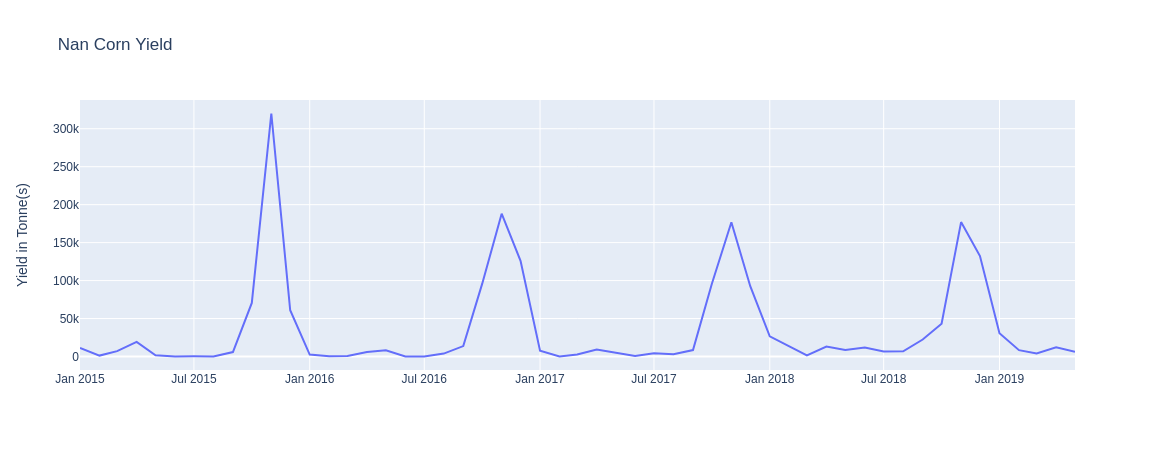

In [6]:
py.iplot({'data':go.Scatter(x=df_nan['ds'], y=df_nan['y'], name='y'),
         'layout':dict(title = 'Nan Corn Yield',
                       yaxis = dict(title = 'Yield in Tonne(s)'))
         })

----

## Model 1: Prophet default parameters

In [43]:
df_train, df_test = df_nan[12:], df_nan[:12]

In [44]:
model = Prophet(seasonality_prior_scale=0.05)
model.fit(df_train)
future = model.make_future_dataframe(periods=24, freq="MS")
forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
n = len(df_nan['y'])
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 22555.671964


In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-01,36025.802619,-18609.930144,32516.540837,36025.795193,36025.809812,-29181.517361,-29181.517361,-29181.517361,-29181.517361,-29181.517361,-29181.517361,0.0,0.0,0.0,6844.285258
1,2020-04-01,36077.237844,-15903.594443,34454.310864,36077.230829,36077.244573,-24957.614462,-24957.614462,-24957.614462,-24957.614462,-24957.614462,-24957.614462,0.0,0.0,0.0,11119.623383
2,2020-03-01,36130.387577,-21726.569237,27192.907778,36130.381102,36130.393900,-34534.522706,-34534.522706,-34534.522706,-34534.522706,-34534.522706,-34534.522706,0.0,0.0,0.0,1595.864871
3,2020-02-01,36180.108295,-23124.859222,29249.962942,36180.102284,36180.114094,-32808.383634,-32808.383634,-32808.383634,-32808.383634,-32808.383634,-32808.383634,0.0,0.0,0.0,3371.724660
4,2020-01-01,36233.258027,-16403.907462,32771.227963,36233.252542,36233.263396,-27467.167487,-27467.167487,-27467.167487,-27467.167487,-27467.167487,-27467.167487,0.0,0.0,0.0,8766.090540


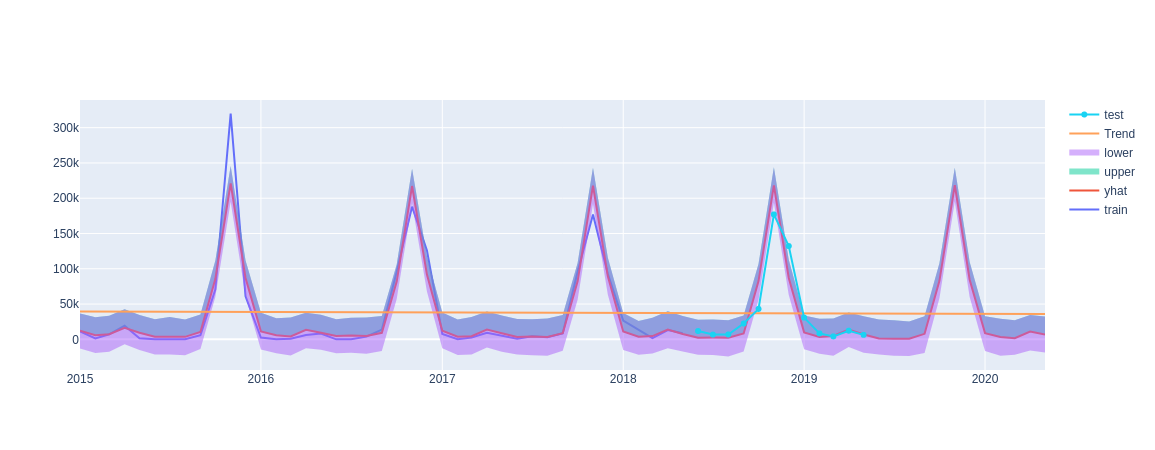

In [47]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

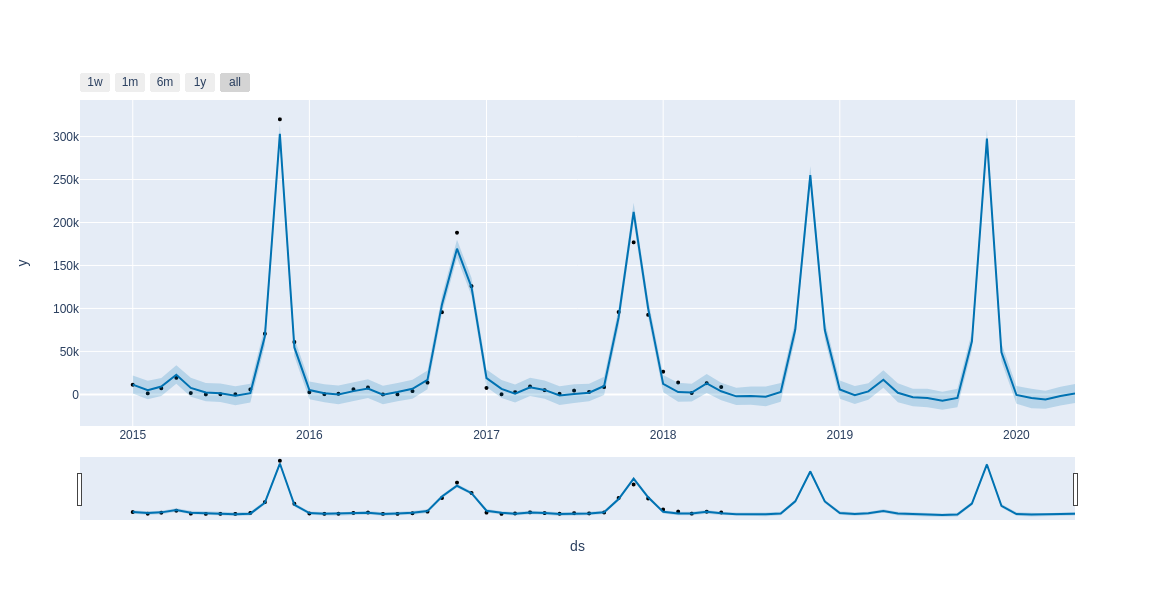

In [12]:
plot_plotly(model, forecast)

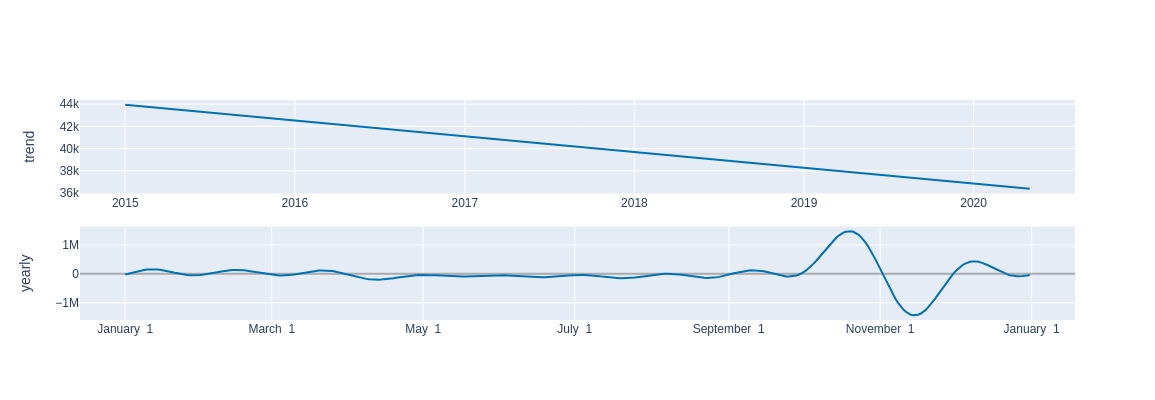

In [13]:
plot_components_plotly(model, forecast)

----

## Model 2: Prophet default parameters with log input

In [14]:
df_train, df_test = df_nan[12:], df_nan[:12]

In [15]:
df_train_log = df_train.copy()
df_train_log['y'] = np.log(df_train['y']+1)

In [16]:
model = Prophet(growth='flat', seasonality_prior_scale=0.08)
model.fit(df_train_log)
future = model.make_future_dataframe(periods=24, freq="MS")
forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])
forecast['yhat'] = np.exp(forecast['yhat'])-1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
n = len(df_nan['y'])
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 23963.417314


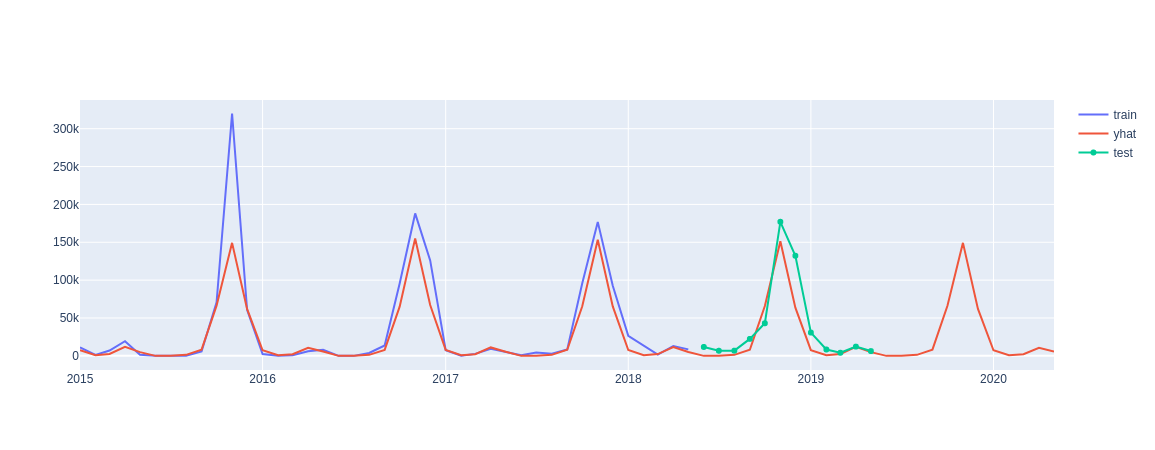

In [18]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
#     go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
#     go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
#     go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

In [19]:
forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

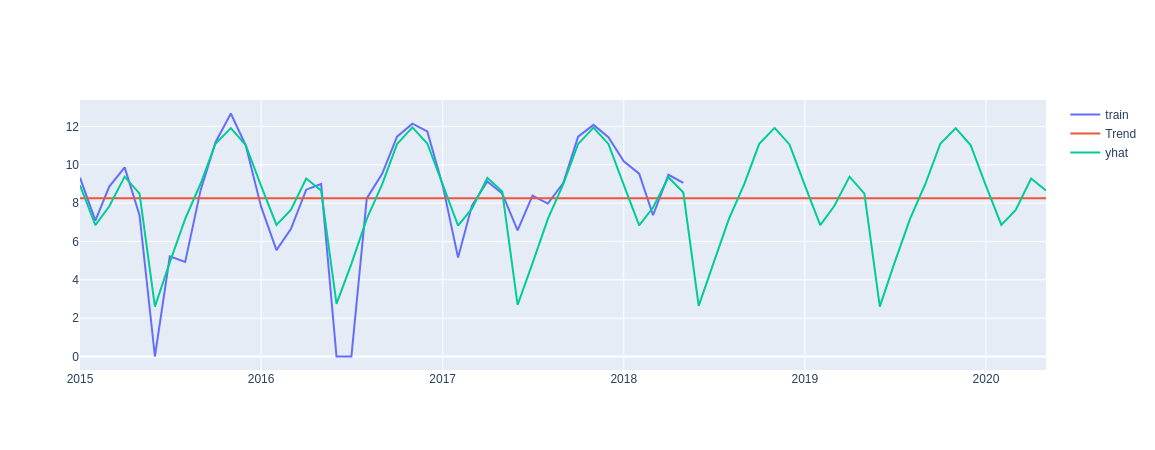

In [20]:
py.iplot([
    go.Scatter(x=df_train_log['ds'], y=df_train_log['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
])

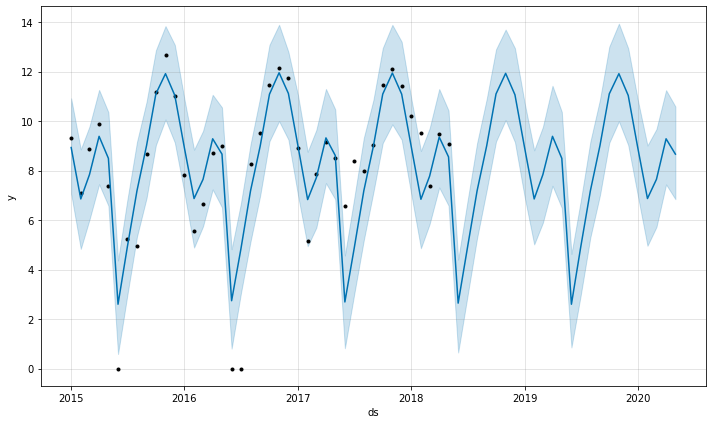

In [21]:
fig1 = model.plot(forecast)

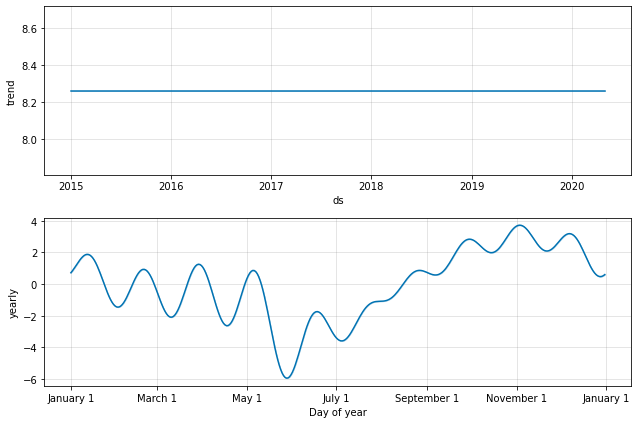

In [22]:
fig2 = model.plot_components(forecast)

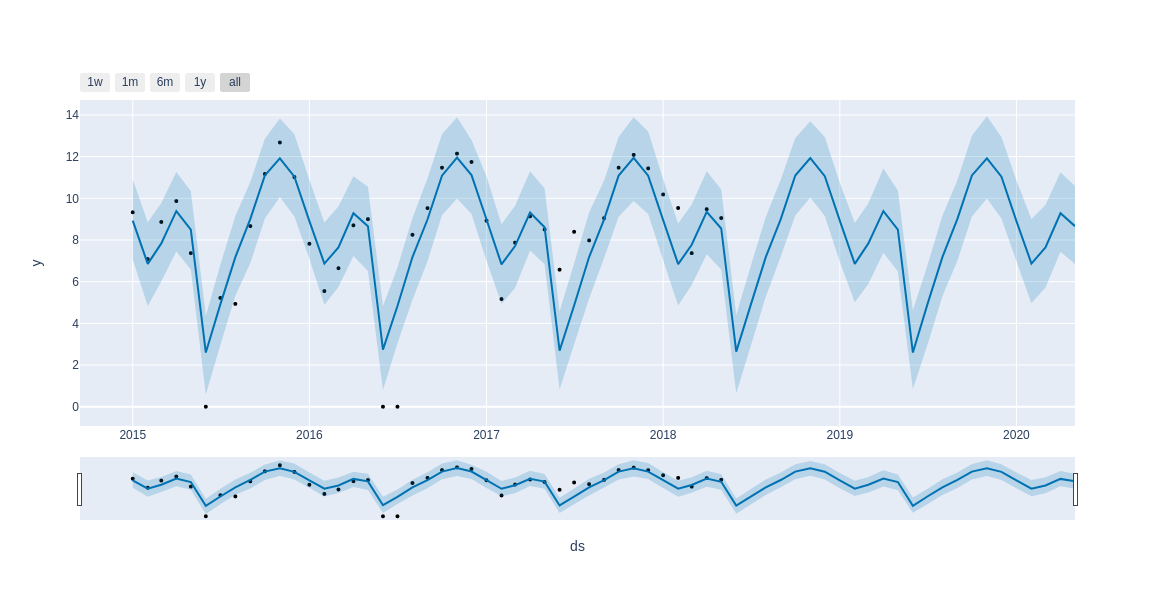

In [23]:
plot_plotly(model, forecast)

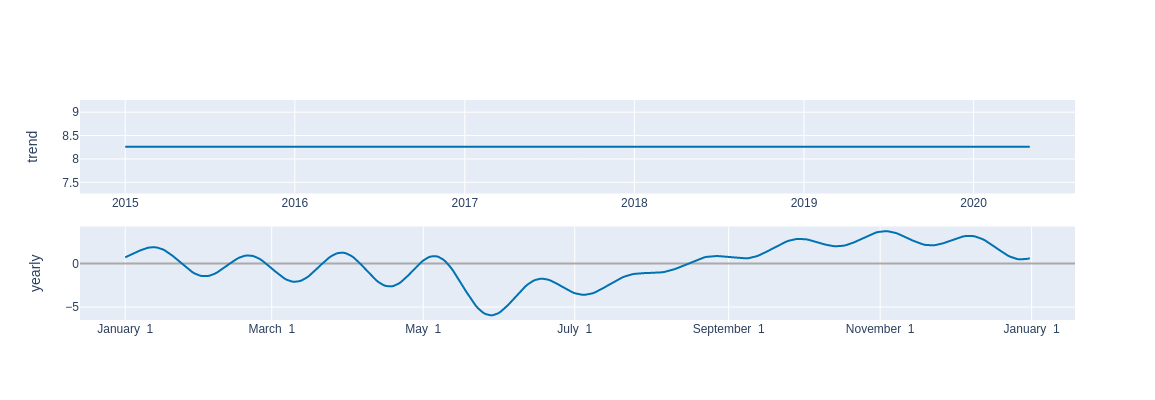

In [24]:
plot_components_plotly(model, forecast)

----

## Model 3: Prophet default parameters with harvesting season

In [116]:
df_train, df_test = df_nan[12:], df_nan[:12]

In [117]:
# Python
def is_harvest_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 10 and date.month <= 12)

df_train['on_season'] = df_train['ds'].apply(is_harvest_season)

<ipython-input-117-7ad79d90708a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [118]:
model = Prophet(seasonality_prior_scale=0.1)
model.add_seasonality(name='monthly_on_season', period=30.5, fourier_order=5, condition_name='on_season')
model.fit(df_train)

future = model.make_future_dataframe(periods=24, freq="MS")
future['on_season'] = future['ds'].apply(is_harvest_season)

forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [119]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
n = len(df_nan['y'])
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 21087.157749


In [120]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly_on_season,monthly_on_season_lower,monthly_on_season_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-01,35076.105618,-12932.185115,29898.607994,35076.060237,35076.153864,-26019.800480,-26019.800480,-26019.800480,0.0,0.0,0.0,-26019.800480,-26019.800480,-26019.800480,0.0,0.0,0.0,9056.305137
1,2020-04-01,35021.115226,-7738.381823,33849.817176,35021.073163,35021.161495,-22198.663395,-22198.663395,-22198.663395,0.0,0.0,0.0,-22198.663395,-22198.663395,-22198.663395,0.0,0.0,0.0,12822.451831
2,2020-03-01,34964.291821,-17380.215332,23896.778594,34964.252957,34964.333902,-30943.129098,-30943.129098,-30943.129098,0.0,0.0,0.0,-30943.129098,-30943.129098,-30943.129098,0.0,0.0,0.0,4021.162723
3,2020-02-01,34911.134442,-14479.542626,28284.963639,34911.097971,34911.174529,-28345.937380,-28345.937380,-28345.937380,0.0,0.0,0.0,-28345.937380,-28345.937380,-28345.937380,0.0,0.0,0.0,6565.197063
4,2020-01-01,34854.311037,-8046.889692,33250.209493,34854.276766,34854.348422,-22015.993706,-22015.993706,-22015.993706,0.0,0.0,0.0,-22015.993706,-22015.993706,-22015.993706,0.0,0.0,0.0,12838.317332


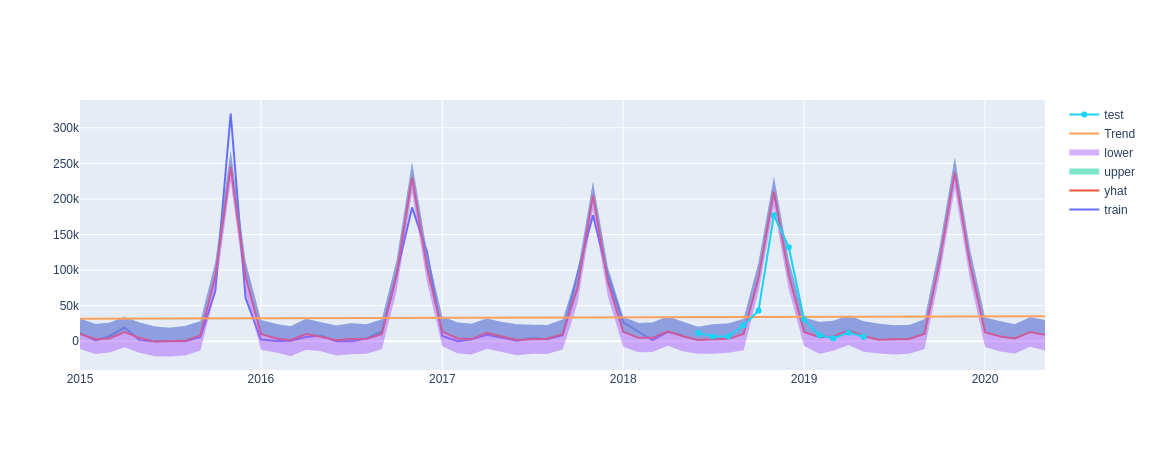

In [121]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

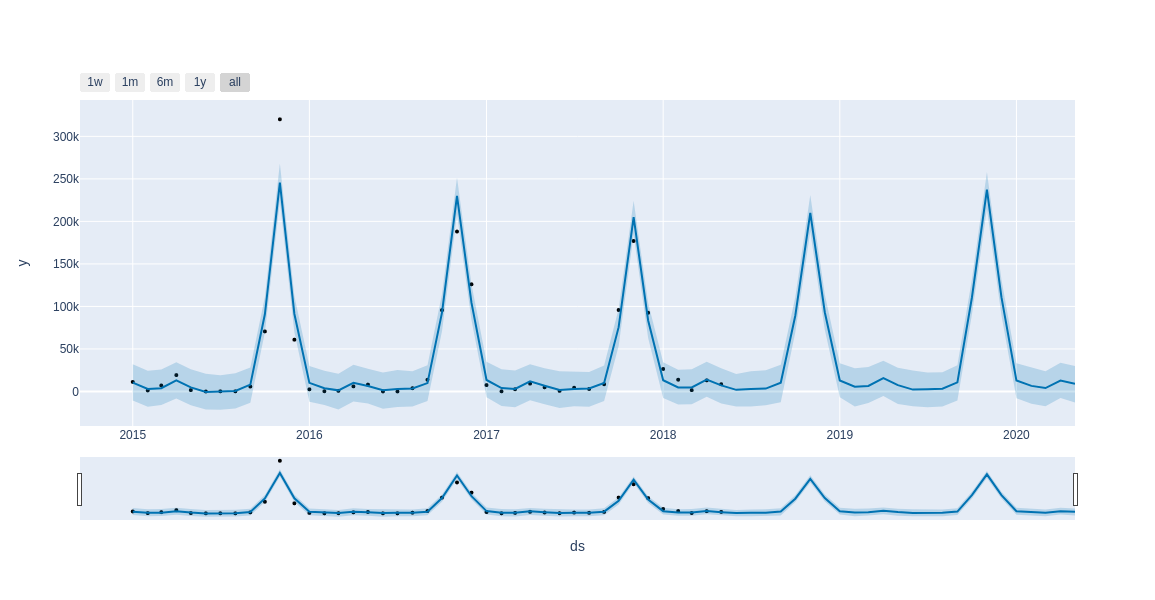

In [122]:
plot_plotly(model, forecast)

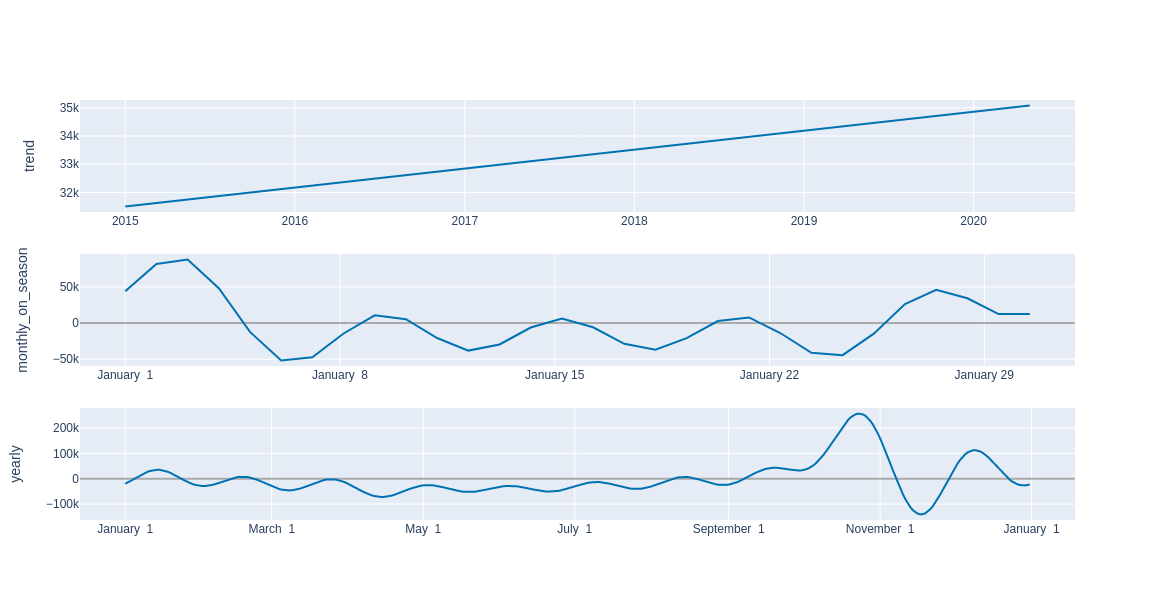

In [123]:
plot_components_plotly(model, forecast)

----

## Model 4: Prophet default parameters with log input and havest season

In [144]:
df_train, df_test = df_nan[12:], df_nan[:12]

In [145]:
# Python
def is_harvest_season(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 10 and date.month <= 12)

df_train['on_season'] = df_train['ds'].apply(is_harvest_season)

<ipython-input-145-7ad79d90708a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
df_train_log = df_train.copy()
df_train_log['y'] = np.log(df_train['y']+1)

In [147]:
model = Prophet(growth='flat', seasonality_prior_scale=0.1)
model.add_seasonality(name='monthly_on_season', period=30.5, fourier_order=5, condition_name='on_season', prior_scale=0.1)

model.fit(df_train_log)
future = model.make_future_dataframe(periods=24, freq="MS")
future['on_season'] = future['ds'].apply(is_harvest_season)

forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])
forecast['yhat'] = np.exp(forecast['yhat'])-1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [148]:
# Sanity check that we are evaluating the forecase at the same date
assert(np.all(forecast[12:24]['ds'].to_numpy() == df_test['ds'].to_numpy()))
# Calculate root mean squared error.
n = len(df_nan['y'])
print('RMSE: %f' % np.sqrt(np.mean((forecast[12:24]['yhat'].to_numpy() - df_test['y'].to_numpy())**2)) )

RMSE: 39287.910657


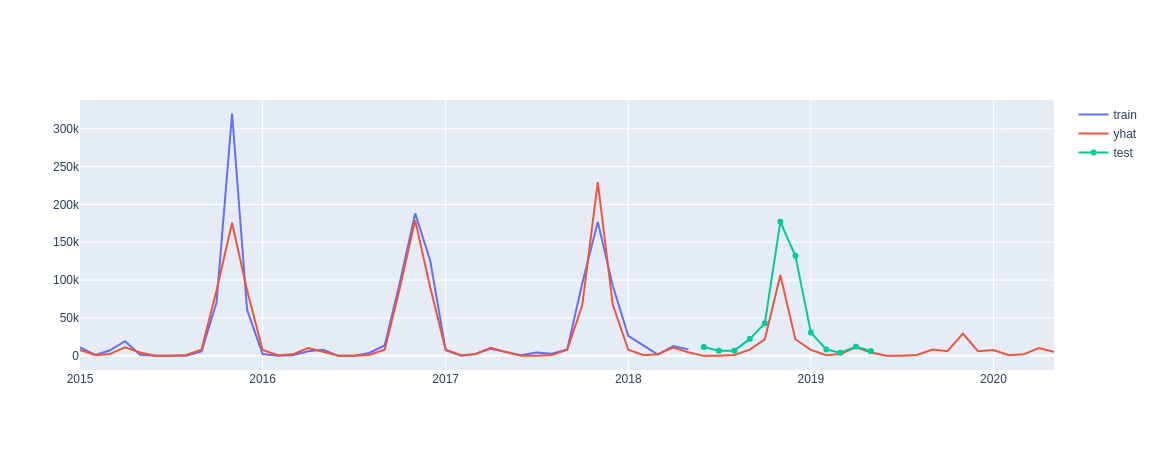

In [149]:
py.iplot([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
#     go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
#     go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
#     go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=df_test['ds'], y=df_test['y'], name='test'),
])

In [150]:
forecast = model.predict(future)
forecast = forecast.sort_values(by='ds', ascending=False).reset_index().drop(columns=['index'])

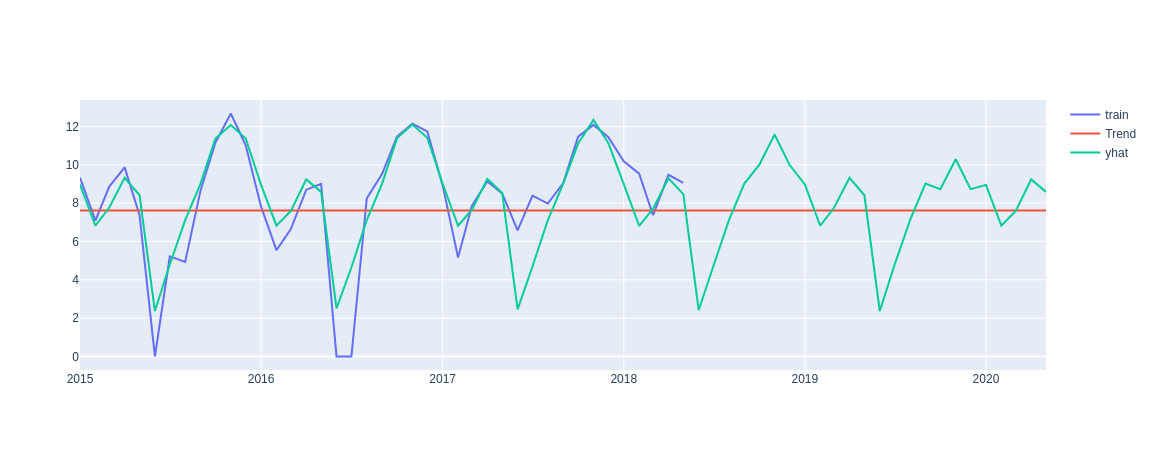

In [151]:
py.iplot([
    go.Scatter(x=df_train_log['ds'], y=df_train_log['y'], name='train'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='yhat'),
])

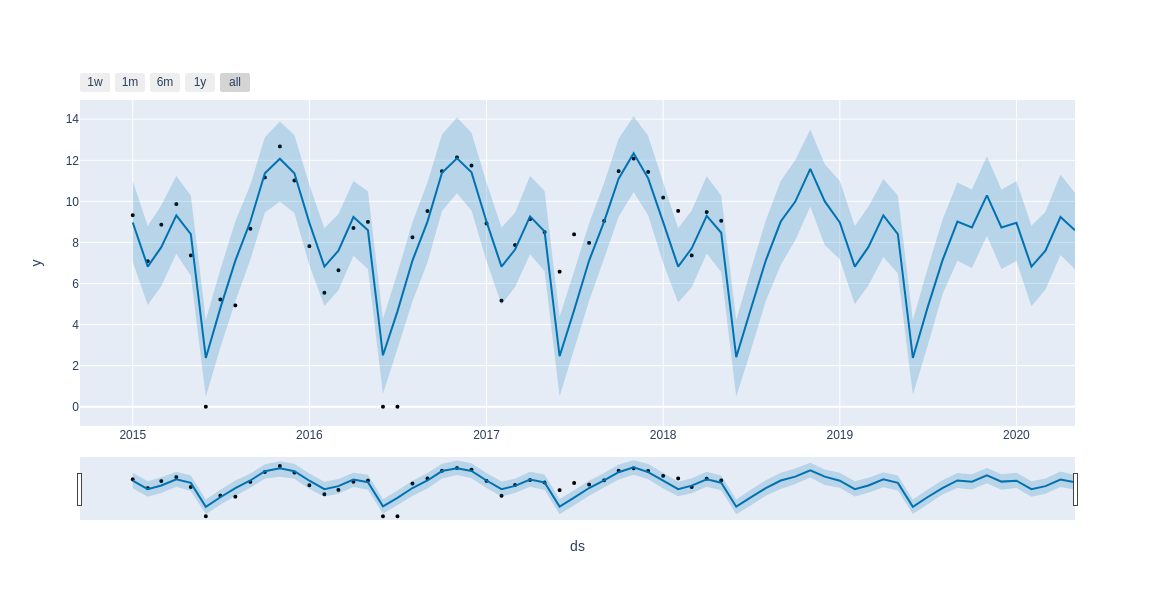

In [152]:
plot_plotly(model, forecast)

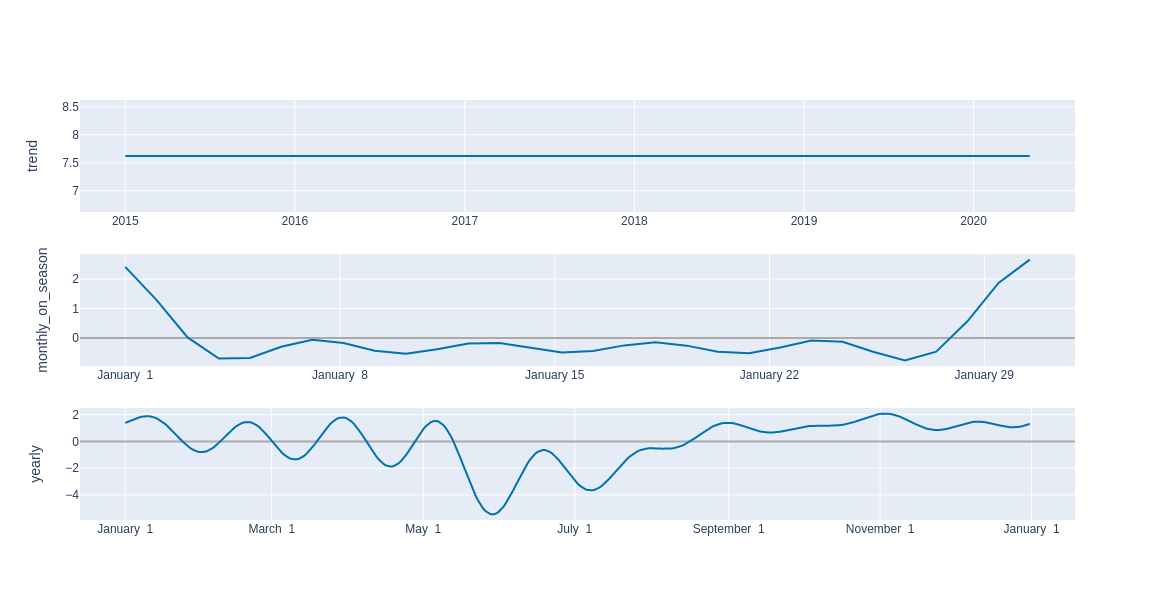

In [153]:
plot_components_plotly(model, forecast)